<a href="https://colab.research.google.com/github/luca-arts/seeingtheimperceptible/blob/main/notebooks/skinRetouching/tests/retouchML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Face Smoothing Detection and Beautification with StyleGAN2


https://github.com/ju-leon/RetouchML

1. First make sure you select **GPU** as runtime type under Runtime > Runtime Type


In [1]:
!pip install 'h5py==2.10.0' --force-reinstall
# numpy versions from 1.20 throw an error further down the road, might need to restart the runtime.
!pip install numpy==1.19.5

  Using cached h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
  Using cached numpy-1.21.5-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation: h5py 2.10.0
    Uninstalling h5py-2.10.0:
      Successfully uninstalled h5py-2.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which 

  Using cached numpy-1.19.5-cp37-cp37m-manylinux2010_x86_64.whl (14.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


2. Linking next cloud

In [2]:
# we'll link the dataset from next-cloud
!curl https://raw.githubusercontent.com/luca-arts/seeingtheimperceptible/main/notebooks/database_mod.py -o /content/database_mod.py

from database_mod import *

link_nextcloud()

nextcloud = '/content/database/'

#input_folder, output_folder = create_io(database=nextcloud,topic='skinRetouching',library='retouchML')
input_folder, output_folder = create_io(database=nextcloud,topic='skinRetouching/retouchML',library='retouchML')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2235  100  2235    0     0  67727      0 --:--:-- --:--:-- --:--:-- 67727
what's the username for nextcloud? colab
what's the password for user colab? ··········
1
Please enter the username to authenticate with server
https://cloud.bxlab.net/remote.php/dav/files/colab/colabfiles/ or hit enter for none.
  Username: Please enter the password to authenticate user colab with server
https://cloud.bxlab.net/remote.php/dav/files/colab/colabfiles/ or hit enter for none.
  Password:  
content of /etc/fstab: https://cloud.bxlab.net/remote.php/dav/files/colab/colabfiles/ /content/database davfs user,rw,auto 0 0


3. Clone Git repository

In [3]:
import os
root_path = '/content/retouchML'
# clone the repository
if not os.path.exists('retouchML'):
  !git clone https://github.com/ju-leon/RetouchML {root_path}

4. Installing a smart progress bar

In [4]:
# Instantly make your loops show a smart progress meter - just wrap any iterable with tqdm(iterable), and you're done!
# means "progress" in Arabic (taqadum, تقدّم) and is an abbreviation for "I love you so much" in Spanish (te quiero demasiado).

#!pip install --force tqdm==4.24.0
#!pip install --force tqdm==4.63.0
!pip install tqdm

5. Tensorflow version check

In [5]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


6. Getting started

creating different folders:
- aligned_images
- raw_images == input_folder
- alignement_vector
- out == output_folder

In [6]:
%cd {root_path}

# make folders
!mkdir aligned_images alignement_vector

%ls

/content/retouchML
mkdir: cannot create directory ‘aligned_images’: File exists
mkdir: cannot create directory ‘alignement_vector’: File exists
 adaptive.py            encoder/                     README.md*
 aligned_images/        ffhq_dataset/                registry.py
 alignement_vector/     fit_faces.py                 robust_loss/
 align_images.py*      'Hand Labeler.ipynb'          run_generator.py*
'Beautify ALAE.ipynb'   launcher.py                  run_metrics.py*
 Beautify.ipynb         Learn_Attractiveness.ipynb   run_projector.py*
 custom_adam.py         LICENSE.txt*                 run_training.py*
 dataloader.py          lreq.py                      scheduler.py
 dataset_tool.py*       metrics/                     swa.py
 defaults.py            model.py                     test_nvcc.cu*
 dnnlib/                net.py                       tracker.py
 Dockerfile*           'Predict Beauty.ipynb'        train_alae.py
 docs/                  pretrained_networks.py*      tra

7. Define the input folder


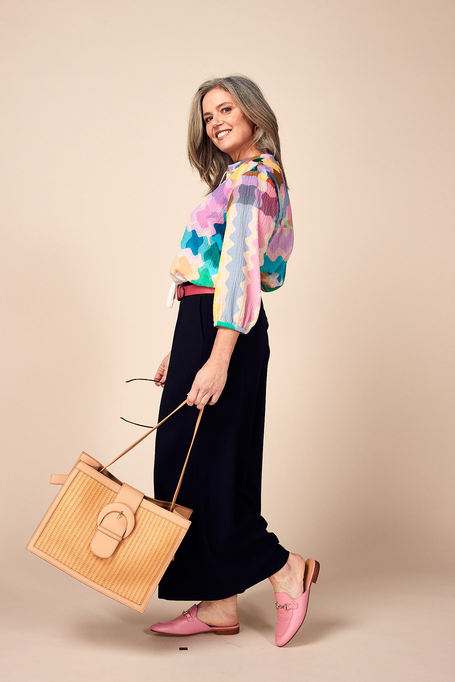

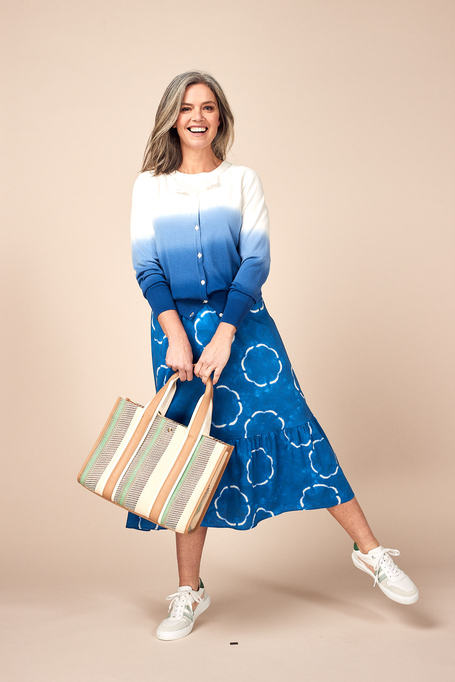

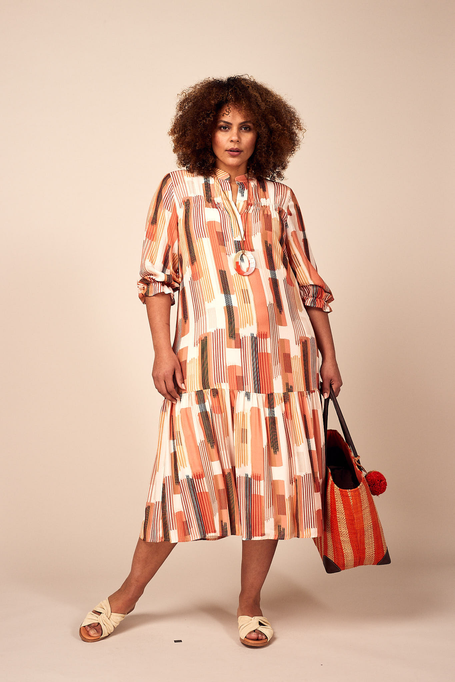

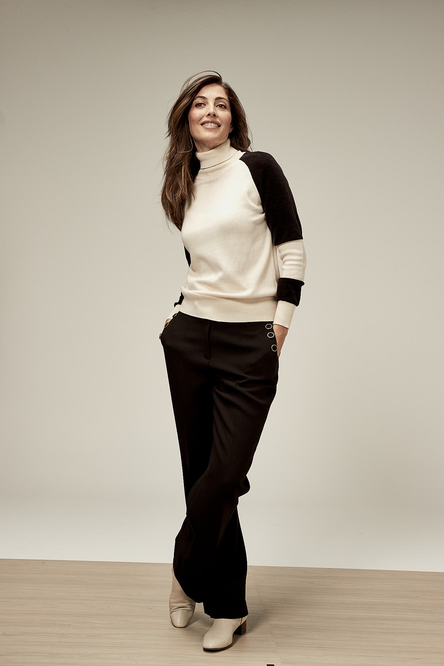

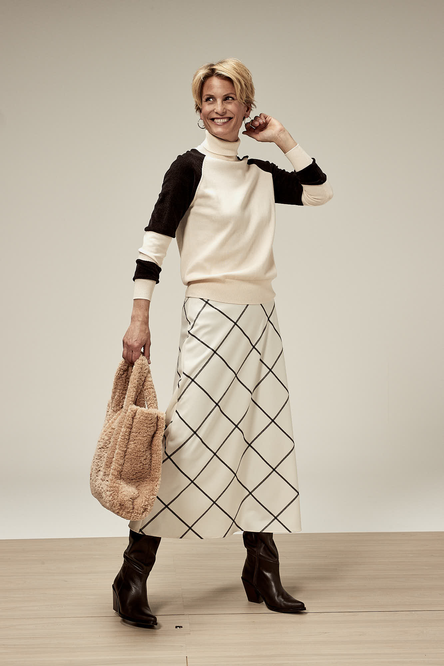

In [7]:
import glob, os
import PIL.Image

# define which images extensions are valid
valid_images = (".jpg",".png")

for f in os.listdir(input_folder):
    if f.endswith(valid_images):
        img = PIL.Image.open(os.path.join(input_folder,f))
        display(img.resize((int(img.size[0]/3), int(img.size[1]/3)), PIL.Image.LANCZOS))


8. Aligning images

Run the following scripts to crop and see the results.

In [8]:
!python align_images.py {input_folder} aligned_images/ alignement_vector/

Using TensorFlow backend.


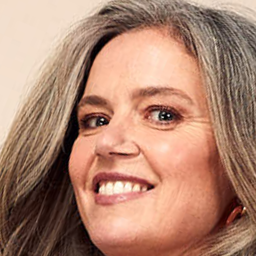

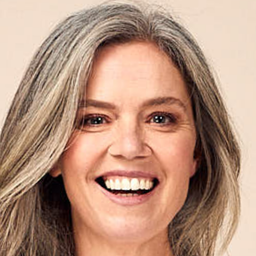

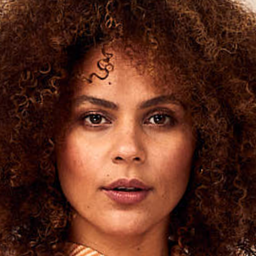

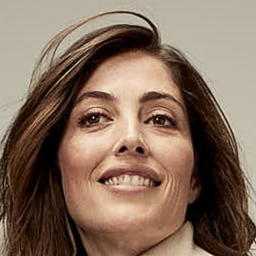

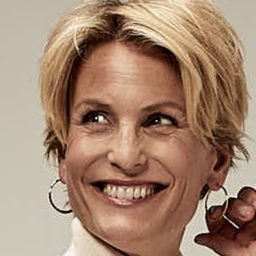

In [9]:
align_path = 'aligned_images/'

# images are last -> first, sorting them from first -> last
for f in sorted(os.listdir(align_path)):
    if f.endswith(valid_images):
        img = PIL.Image.open(align_path + f)
        display(img.resize((256,256), PIL.Image.LANCZOS))

9. Encoding

We need to translate what we can see into a latent vector.
We will use a StyleGan encoder.

This will take a while, so sit back and let Googles GPU do their jobs...

In [10]:
!python encode_images.py --help

Using TensorFlow backend.
usage: encode_images.py [-h] [--data_dir DATA_DIR] [--mask_dir MASK_DIR]
                        [--load_last LOAD_LAST] [--dlatent_avg DLATENT_AVG]
                        [--model_url MODEL_URL] [--model_res MODEL_RES]
                        [--batch_size BATCH_SIZE] [--optimizer OPTIMIZER]
                        [--vgg_url VGG_URL] [--image_size IMAGE_SIZE]
                        [--resnet_image_size RESNET_IMAGE_SIZE] [--lr LR]
                        [--decay_rate DECAY_RATE] [--iterations ITERATIONS]
                        [--decay_steps DECAY_STEPS]
                        [--early_stopping [EARLY_STOPPING]]
                        [--early_stopping_threshold EARLY_STOPPING_THRESHOLD]
                        [--early_stopping_patience EARLY_STOPPING_PATIENCE]
                        [--load_effnet LOAD_EFFNET]
                        [--load_resnet LOAD_RESNET]
                        [--use_preprocess_input [USE_PREPROCESS_INPUT]]
                 

In [17]:
!python encode_images.py aligned_images/ generated_images/ latent_representations/ \
    --vgg_url=https://rolux.org/media/stylegan/vgg16_zhang_perceptual.pkl \
    --lr=0.4 --iterations=200 \
    --use_best_loss=True --early_stopping=True --load_resnet=True 

Using TensorFlow backend.
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
2022-03-23 15:22:12.973599: W tensorflow/core/common_runtime/bfc_allocator.cc:305] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
  0% 0/1 [00:00<?, ?it/s]Rects:
rectangles[[(35, 57) (221, 242)]]
Saving mask masks/LB_0001_01.png
Loading mask masks/LB_0001_01.png

  0% 0/200 [00:00<?, ?it/s]2022-03-23 15:22:35.013356: W tensorflow/core/common_runtime/bfc_allocator.cc:239] Allocator (GPU_0_bfc

10. Result

The following image is the encoded image in latent space.

It should look pretty similar to the original representation, although it might vary slightly.


If you're not happy with the result try running the encoding again with different parameters.

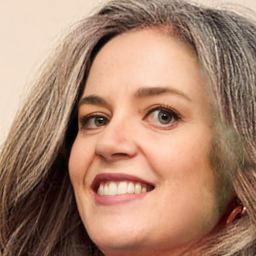

In [18]:
path = "generated_images/"
for f in sorted(os.listdir(path)):
    if f.endswith(valid_images):
        img = PIL.Image.open(path + f)

        display(img.resize((256,256), PIL.Image.LANCZOS))

In [19]:
import shutil

# make folders
!mkdir models

# copy keras model from nextcloud to models in retouchML
shutil.copyfile('/content/database/skinRetouching/retouchML/models/no_pca.keras','/content/retouchML/models/no_pca.keras')

mkdir: cannot create directory ‘models’: File exists


'/content/retouchML/models/no_pca.keras'

In [20]:
import keras
model = keras.models.load_model('models/no_pca.keras') 

In [21]:
import math
import pickle
import PIL.Image
import numpy as np

#import config
import dnnlib
import dnnlib.tflib as tflib
from encoder.generator_model import Generator
URL_FFHQ = 'https://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl'
tflib.init_tf()
with dnnlib.util.open_url(URL_FFHQ, cache_dir="cache") as f:
    generator_network, discriminator_network, Gs_network = pickle.load(f)

generator = Generator(Gs_network, batch_size=1, randomize_noise=False)

model_res = 1024
model_scale = int(2*(math.log(model_res,2)-1))

def generate_raw_image(latent_vector):
    latent_vector = latent_vector.reshape((1, model_scale, 512))
    generator.set_dlatents(latent_vector)
    return generator.generate_images()[0]

def generate_image(latent_vector):
    img_array = generate_raw_image(latent_vector)
    img = PIL.Image.fromarray(img_array, 'RGB')
    return img

ValueError: ignored

11. Computing the gradient - better approach

In order to improve the face, we'll follow the gradient.
This should give us a better version of the image that is still close to the original image.

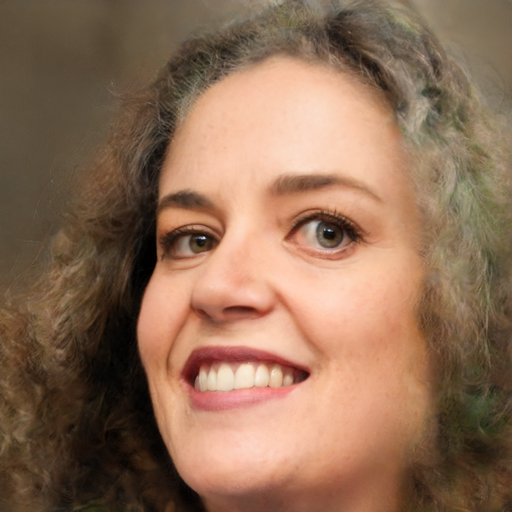

667.6912
668.50055


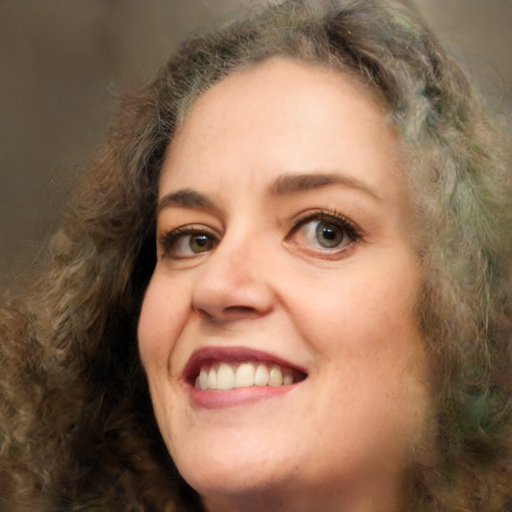

668.5434


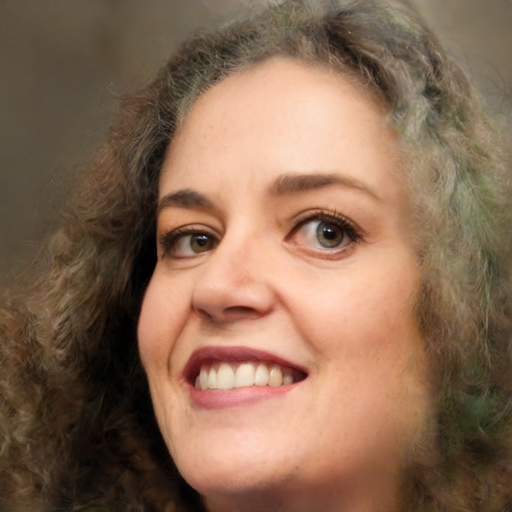

[673.679   683.38904 633.14514 663.02106 659.5709  650.63184 634.2648
 723.89514 666.8126  705.4067  673.1738  664.62256 650.8199  685.97925
 664.20996 662.6068  666.75195 671.8009 ]


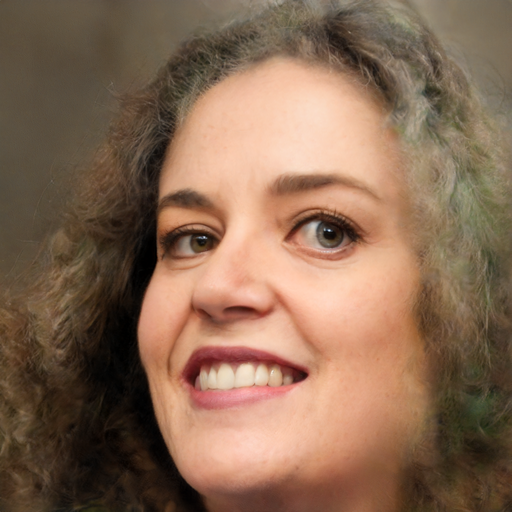

In [22]:
import copy
from tqdm import tqdm

latent_vector = np.load('./latent_representations/LB_0001_01.npy')
img = generate_image(latent_vector)
display(img.resize((512,512),PIL.Image.LANCZOS))

predictions = model.predict(latent_vector).reshape(-1)
print(np.mean(predictions))


for x in range(2):
  x_tensor = tf.convert_to_tensor(latent_vector, dtype=tf.float32)

  with tf.GradientTape() as t:
      t.watch(x_tensor)
      output = model(x_tensor)

  gradients = tf.gradients(output, x_tensor)

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    result_output=np.array(sess.run(gradients)).reshape(18,512)

  latent_vector += result_output
  print(np.mean(model.predict(latent_vector)))
  img = generate_image(latent_vector)
  display(img.resize((512,512),PIL.Image.LANCZOS))

predictions = model.predict(latent_vector).reshape(-1)
print(predictions)

img = generate_image(latent_vector)
display(img.resize((512,512),PIL.Image.LANCZOS))
img.save("generated_images/LB_0001_01.png", "PNG")

In [23]:
#/content/RetouchML/masks/IMG_20200209_150540_01.png
#/content/drive/My Drive/RetouchML/raw_images/pexels-anna-shvets-4672292.jpg
#/content/drive/My Drive/RetouchML/raw_images/pexels-sound-on-3756989.jpg
img_name = "LB_0001_01.jpg"
#raw_path = "raw_images/" + img_name
raw_path = input_folder + '/' + img_name

#out_path = "out/" + img_name
out_path = output_folder + '/' + img_name
face_path = "generated_images/" 
mask_path = "masks/"
vector_path = "alignement_vector/"
!python fit_faces.py $raw_path $face_path $mask_path $vector_path $out_path


Using TensorFlow backend.
Traceback (most recent call last):
  File "fit_faces.py", line 50, in <module>
    main()
  File "fit_faces.py", line 39, in main
    copyfile(args.src_file, args.dst_file)
  File "/usr/lib/python3.7/shutil.py", line 120, in copyfile
    with open(src, 'rb') as fsrc:
FileNotFoundError: [Errno 2] No such file or directory: '/content/database/skinRetouching/retouchML/input/LB_0001_01.jpg'


In [24]:
#path = 'out/'
path = output_folder + '/'
valid_images = (".jpg",".png")
for f in os.listdir(path):
    if f.endswith(valid_images):
        img = PIL.Image.open(path + f)
        display(img.resize((int(img.size[0]/3), int(img.size[1]/3)), PIL.Image.LANCZOS))


#### Done